In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


from sklearn import preprocessing
from xgboost import XGBClassifier

# Other Libraries
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter 
rs = 42
def compute_metrics (y_te2,y_p,string):
    print('\n %s'%string)
    print('CONFUSION MATRIX')
    print(metrics.confusion_matrix(y_te2,y_p))
    print(classification_report(y_te2, y_p))
    print('\nROC CURVE: %2.2f'%roc_auc_score(y_te2,y_p))

def plotting_ROC_curve(X_te,y_te,model):
    plt.figure()
    metrics.plot_roc_curve(model,X_te,y_te)
    plt.plot([0,1],[0,1],label='baseline',c='red')
    plt.legend(loc='lower right')
    plt.show()
    
def Ratio10(y,string):
    suma = Counter(y)[0]+Counter(y)[1]
    print('\n'+string)  
    print(Counter(y))
    print('0: %3.2f%%\n1: %3.2f%%' % (100*Counter(y)[0]/suma,100*Counter(y)[1]/suma))

def histo(data,var):
    fig=plt.figure()
    colors = np.array(['#0101DF','#DF0101','#01DF01'])
    sns.countplot(var,data=data,palette=colors)
    plt.title('0/1 Distribution (0: No Stalling || 1: Stalling Event',fontsize=14)
    plt.show()
    
def featImp(model,features):
    print('Features: %s' %features)
    feat_imp = pd.Series(model.feature_importances_, features).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

Using TensorFlow backend.


Index(['No.', 'Time', '∆t', 'Protocol', 'pkt_len', 'ip_len', 'tcp_hea_len',
       'tcp_flag_ack', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg',
       'tcp_flag_psh', 'tcp_flag_rst', 'tcp_flag_syn', 'tcp_flag_fin',
       'tcp_win_si2', 'delay', 'capture', 'prebuffering', 'stalling_event'],
      dtype='object')

dataset[stalling_event]
Counter({0: 1426743, 1: 113031})
0: 92.66%
1: 7.34%

y (SMOTE)
Counter({0: 1426743, 1: 1426743})
0: 50.00%
1: 50.00%


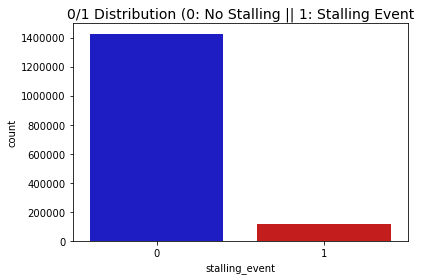

In [2]:
dataset = pd.read_csv('../../output/df_general.csv', sep=',')
dataset = dataset.dropna()

print(dataset.columns)
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

y = dataset['stalling_event']
X = dataset.drop(['No.','Protocol','prebuffering','Time','delay','capture','stalling_event'],axis=1)

smote = SMOTE(sampling_strategy='minority',random_state=rs,n_jobs=-1)
X, y = smote.fit_sample(X.values, y.values)
Ratio10(y,'y (SMOTE)')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

norm = preprocessing.MinMaxScaler()
X = norm.fit_transform(X)

In [ ]:
'''model = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=5,
                       min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', 
                       nthread=4, scale_pos_weight=1, seed=rs)
model.fit(X_train,y_train)'''

In [ ]:
'''featImp(model,['∆t', 'pkt_len', 'ip_len', 'tcp_hea_len', 'tcp_flag_ack',
       'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_psh',
       'tcp_flag_rst', 'tcp_flag_syn', 'tcp_flag_fin', 'tcp_win_si2'])'''


In [3]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search
param_test1 = {
 'n_estimators':range(100,1700,500)
}
gsearch1 = GridSearchCV(estimator= XGBClassifier(learning_rate = 0.1, max_depth=8, max_features='sqrt',
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', seed=rs,
                                                  scale_pos_weight=1
                                                  ), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3,verbose=1) #probar scoring 'roc_auc'
gsearch1.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 103.7min finished
c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=4,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(100, 1700, 500)},
             pre_dispatch='2*n_jobs', refit=True, return_train_sc

In [4]:
print(gsearch1.cv_results_)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'mean_fit_time': array([ 226.0576671 , 1347.90633353, 2616.69522587, 2921.51039577]), 'std_fit_time': array([  2.32262758,  13.87059573,  13.6539311 , 575.50591999]), 'mean_score_time': array([ 3.84533509, 21.6691734 , 36.8143301 , 32.88133264]), 'std_score_time': array([0.25779599, 2.39092804, 5.09417881, 9.03378397]), 'param_n_estimators': masked_array(data=[100, 600, 1100, 1600],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 600}, {'n_estimators': 1100}, {'n_estimators': 1600}], 'split0_test_score': array([0.72894228, 0.75529991, 0.76489686, 0.77058262]), 'split1_test_score': array([0.72559949, 0.751087  , 0.76259813, 0.76937889]), 'split2_test_score': array([0.72642253, 0.75013722, 0.76187   , 0.7686405 ]), 'mean_test_score': array([0.7269881 , 0.75217471, 0.76312166, 0.769534  ]), 'std_test_score': array([0.00142208, 0.00224361, 0.00128997, 0.00080042]), 'rank_test_score': array

In [4]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search
param_test2 = {
    'max_depth':range(5,10,1),
    'gamma':[0.01,0.1,0.2],
    'subsample':[0.6,0.7,0.8,0.9]
}
gsearch2 = GridSearchCV(estimator= XGBClassifier(learning_rate = 0.1, n_estimators=150, max_features='sqrt',
                                                  min_child_weight=1, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', seed=rs,
                                                  scale_pos_weight=1
                                                  ), 
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=3,verbose=1) #probar scoring 'roc_auc'
gsearch2.fit(X_train,y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 54.1min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 242.5min finished
c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=150, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.01, 0.1, 0.2], 'max_depth': range(5, 10),
                         'subsample': [0.6, 0.7, 0

In [5]:
print(gsearch2.cv_results_)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'mean_fit_time': array([252.25333079, 240.64900104, 230.98633258, 222.40366427,
       288.68799845, 278.74033213, 269.26402378, 257.51169062,
       335.96939437, 314.36268528, 299.83933512, 292.23700237,
       369.50780257, 355.45127002, 339.97086422, 322.94059849,
       414.64633075, 388.96266715, 369.89699952, 353.02566282,
       261.0670681 , 258.7183547 , 251.90002616, 242.93341549,
       310.42699941, 294.8819983 , 277.52400057, 260.02399826,
       338.61699669, 327.49499853, 319.52656658, 313.06636794,
       376.77099665, 362.82666628, 347.4786675 , 331.70133392,
       424.06899762, 401.64266531, 382.08033291, 362.63466382,
       260.34299771, 250.31366412, 244.27699765, 238.87466415,
       300.44833565, 287.77733278, 275.4288617 , 265.64891966,
       332.79399967, 318.486998  , 305.06033246, 290.03566289,
       373.20299737, 355.72666685, 339.56766486, 324.3349967 ,
       414.80366619, 393.82133269, 374.74899936, 356.10866451]), 'std_fit_time': array([0.71949211, 

In [6]:
param_test3 = {
    'colsample_bytree':[0.6,0.7,0.8,0.9]
}
gsearch3 = GridSearchCV(estimator= XGBClassifier(learning_rate = 0.1, n_estimators=150, max_features='sqrt',
                                                  min_child_weight=1, gamma=0.1,max_depth=9, 
                                                  objective= 'binary:logistic', seed=rs, subsample=0.6,
                                                  scale_pos_weight=1
                                                  ), 
                        param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=3,verbose=1) #probar scoring 'roc_auc'
gsearch3.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 21.2min finished
c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=150, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=0.6, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [7]:
print(gsearch3.cv_results_)
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'mean_fit_time': array([341.83207099, 393.49628917, 414.83227634, 436.03566575]), 'std_fit_time': array([1.02059983, 1.28627751, 0.84852466, 2.51588469]), 'mean_score_time': array([10.845529  , 10.69551396, 10.65200154,  8.03866665]), 'std_score_time': array([0.28570115, 0.2555128 , 0.06013862, 0.23870766]), 'param_colsample_bytree': masked_array(data=[0.6, 0.7, 0.8, 0.9],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'colsample_bytree': 0.6}, {'colsample_bytree': 0.7}, {'colsample_bytree': 0.8}, {'colsample_bytree': 0.9}], 'split0_test_score': array([0.74173408, 0.74185443, 0.74082879, 0.73968351]), 'split1_test_score': array([0.73785372, 0.7394153 , 0.73881976, 0.73807834]), 'split2_test_score': array([0.74140307, 0.74141213, 0.74092148, 0.73848344]), 'mean_test_score': array([0.74033029, 0.74089395, 0.74019001, 0.73874843]), 'std_test_score': array([0.00175641, 0.00106104, 0.00096965, 0.00068157]), 'rank_test_score': a

In [8]:
param_test4 = {
    'n_estimators':[1500,2500,3500]
}
gsearch4 = GridSearchCV(estimator= XGBClassifier(learning_rate = 0.1, max_features='sqrt',
                                                  min_child_weight=1, gamma=0.1,max_depth=9, colsample_bytree=0.7,
                                                  objective= 'binary:logistic', seed=rs, subsample=0.6,
                                                  scale_pos_weight=1
                                                  ), 
                        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=3,verbose=1) #probar scoring 'roc_auc'
gsearch4.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 336.6min finished
c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.7, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=0.6, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': [1500, 2500, 3500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_

In [9]:
print(gsearch4.cv_results_)
print(gsearch4.best_params_)
print(gsearch4.best_score_)

{'mean_fit_time': array([3851.6841561 , 6462.33258994, 8794.80665787]), 'std_fit_time': array([  9.08961544,  11.63216484, 217.78697429]), 'mean_score_time': array([278.57599958, 665.50052762, 552.87947583]), 'std_score_time': array([ 7.56022696, 46.24738201, 94.30468858]), 'param_n_estimators': masked_array(data=[1500, 2500, 3500],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 1500}, {'n_estimators': 2500}, {'n_estimators': 3500}], 'split0_test_score': array([0.77427905, 0.77961188, 0.78177384]), 'split1_test_score': array([0.77605825, 0.78141711, 0.78397872]), 'split2_test_score': array([0.77475742, 0.77938431, 0.78150944]), 'mean_test_score': array([0.77503157, 0.78013777, 0.78242067]), 'std_test_score': array([0.00075178, 0.00090939, 0.00110699]), 'rank_test_score': array([3, 2, 1])}
{'n_estimators': 3500}
0.782420669156472


In [10]:
model = XGBClassifier(n_estimators=4000,learning_rate = 0.1, max_features='sqrt', min_child_weight=1, 
              gamma=0.1,max_depth=9, colsample_bytree=0.7, scale_pos_weight=1,
              objective= 'binary:logistic', seed=rs, subsample=0.6
              )

model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=4000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
              subsample=0.6, verbosity=1)

[0.00838422 0.00362707 0.00420873 0.00317106 0.0100402  0.
 0.         0.         0.00742942 0.01928242 0.0075601  0.00237014
 0.93392664]

 XGBoost
CONFUSION MATRIX
[[209811  74927]
 [100472 185488]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71    284738
           1       0.71      0.65      0.68    285960

    accuracy                           0.69    570698
   macro avg       0.69      0.69      0.69    570698
weighted avg       0.69      0.69      0.69    570698


ROC CURVE: 0.69


<Figure size 432x288 with 0 Axes>

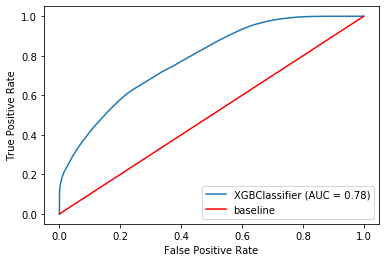

In [11]:
y_pred = model.predict(X_test)
print(model.feature_importances_)
compute_metrics(y_test,y_pred,'XGBoost')
plotting_ROC_curve(X_test,y_test,model=model)